In [1]:
import numpy as np
from pymoo.optimize import minimize
from jobshop.params import JobShopRandomParams
from jobshop.heuristic.brkga import BRKGA, Decoder, LSDecoder, JobShopProblem, DuplicatesEncoder
from jobshop.heuristic.brkga.termination import TargetTermination

In [2]:
params = JobShopRandomParams(10, 10, t_span=(0, 20), seed=12)  # 10, 10 seed 12 known optimal solution 153

In [5]:
brkga = BRKGA(
    pop_size=100,
    perc_elite=0.2,
    perc_mutants=0.15,
    bias=0.8,
    eliminate_duplicates=DuplicatesEncoder(1e-3),
)
problem = JobShopProblem(params, LSDecoder)

In [6]:
res = minimize(problem, brkga, termination=TargetTermination(200, 153), verbose=True, seed=42)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 |  2.141200E+02 |  1.730000E+02
     2 |      180 |  2.087200E+02 |  1.730000E+02
     3 |      260 |  2.083900E+02 |  1.730000E+02
     4 |      340 |  2.041600E+02 |  1.730000E+02
     5 |      420 |  2.071700E+02 |  1.720000E+02
     6 |      500 |  2.034800E+02 |  1.720000E+02
     7 |      580 |  2.062100E+02 |  1.720000E+02
     8 |      660 |  2.032200E+02 |  1.720000E+02
     9 |      740 |  1.985600E+02 |  1.690000E+02
    10 |      820 |  1.988400E+02 |  1.690000E+02
    11 |      900 |  2.022200E+02 |  1.690000E+02
    12 |      980 |  2.010500E+02 |  1.690000E+02
    13 |     1060 |  2.006200E+02 |  1.660000E+02
    14 |     1140 |  1.982300E+02 |  1.660000E+02
    15 |     1220 |  1.975700E+02 |  1.660000E+02
    16 |     1300 |  1.987800E+02 |  1.660000E+02
    17 |     1380 |  2.022100E+02 |  1.660000E+02
    18 |     1460 |  2.005400E+02 |  1.660000E+02
    19 |     1540 |  1.962700E+02 |  1.650000E+02


In [7]:
graph = problem.decoder.build_graph_from_string(res.X)

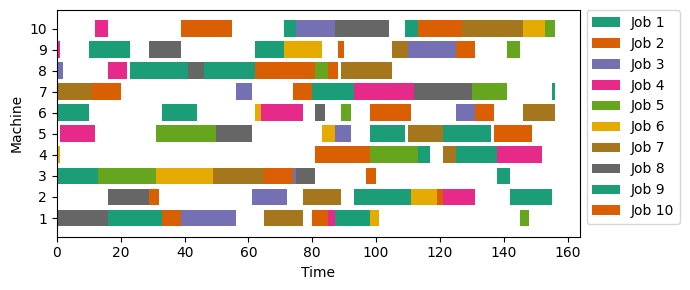

In [8]:
graph.plot()

In [13]:
import numpy as np
from jobshop.heuristic.operations import Graph


def get_constr_Q(graph: Graph):
    Q = []
    for j, machines in graph.seq.items():
        Q.append((machines[0], j))
    return Q


def semi_guided_makespan(graph: Graph, pheno, k=3, alpha=0.5):
    """Do a semi-greedy construction based on incremental makespan

    Parameters
    ----------
    graph : Graph
        Problem in a graph structure
    
    alpha : float, optional
        Greedy criterion parameter, by default 0.9
    """
    # Assert pheno is a list
    pheno = list(pheno)
    
    # Get initial candidates
    Q = get_constr_Q(graph)
    C = 0
    k = 0
    max_iter = len(graph.jobs) * len(graph.machines) + 1

    # Iterate if there's additional jobs to include
    while len(Q) >= 1 and k <= max_iter:
        
        k = k + 1

        # Start
        S_best = None
        c_best = float("inf")
        R = {}
        
        # Restricted candidate list is a set of next jobs
        if np.random.rand() <= alpha:
            RCL = set(pheno[:k])
        else:
            RCL = set([pheno[0]])

        # Iterate over feasible solutions
        for q in Q:
            
            # Add new item to labeled
            m, j = q
            
            # Move to next if job is not considered
            if j not in RCL:
                continue
            
            # Get elements of graph
            d = graph.O[m, j].duration
            r = 0
            
            # Get preceding
            PJ = graph.precede_job(m, j)
            prev_jobs = graph.M[m].jobs
            if len(prev_jobs) >= 1:
                last_job = graph.M[m].jobs[-1]
                PM = graph.O[m, last_job]
            else:
                PM = None
            
            # Update minumum release
            if PJ is not None:
                r = max(r, PJ.release + PJ.duration)
            if PM is not None:
                r = max(r, PM.release + PM.duration)
            R[m, j] = r
            
            # Update C_pot
            C_pot = max(r + d, C)
            if C_pot <= c_best:
                S_best = q
                c_best = C_pot
            
        # Add random element
        new_element = S_best
        m, j = new_element
        
        graph.O[m, j].release = R[m, j]
        graph.M[m].add_job(j)
        Q.pop(Q.index((m, j)))
        pheno.remove(j)
        
        # Update C
        C = c_best
        
        # Get next machine of job (now feasible)
        SJ = graph.follow_job(m, j)
        if SJ is not None:
            Q.append(SJ.code)

In [40]:
from jobshop.heuristic.evaluation import calc_makespan, calc_tails
from jobshop.heuristic.local_search import get_critical, local_search


class GreedyDecoder(LSDecoder):
    
    def build_graph(self, pheno):
        graph = Graph(self.machines, self.jobs, self.p_times, self.seq)
        semi_guided_makespan(graph, pheno, k=3, alpha=0.0)
        calc_makespan(graph)
        calc_tails(graph)
        get_critical(graph)
        return local_search(graph)

In [41]:
problem = JobShopProblem(params, GreedyDecoder)

In [42]:
res = minimize(problem, brkga, termination=TargetTermination(200, 153), verbose=True, seed=42)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 |  2.141200E+02 |  1.730000E+02
     2 |      180 |  2.092400E+02 |  1.730000E+02
     3 |      260 |  2.052700E+02 |  1.730000E+02
     4 |      340 |  2.050000E+02 |  1.690000E+02
     5 |      420 |  2.092200E+02 |  1.690000E+02
     6 |      500 |  2.042200E+02 |  1.670000E+02
     7 |      580 |  2.012800E+02 |  1.670000E+02
     8 |      660 |  2.013300E+02 |  1.670000E+02
     9 |      740 |  1.985100E+02 |  1.670000E+02
    10 |      820 |  1.976400E+02 |  1.670000E+02
    11 |      900 |  2.018700E+02 |  1.670000E+02
    12 |      980 |  2.001900E+02 |  1.670000E+02
    13 |     1060 |  1.968600E+02 |  1.670000E+02
    14 |     1140 |  2.001100E+02 |  1.670000E+02
    15 |     1220 |  1.990200E+02 |  1.660000E+02
    16 |     1300 |  2.005100E+02 |  1.660000E+02
    17 |     1380 |  1.968100E+02 |  1.660000E+02
    18 |     1460 |  1.980600E+02 |  1.660000E+02
    19 |     1540 |  1.980400E+02 |  1.660000E+02


KeyboardInterrupt: 

In [39]:
res.pop.get("F")

array([[167.],
       [176.],
       [179.],
       [180.],
       [180.],
       [181.],
       [181.],
       [181.],
       [182.],
       [183.],
       [183.],
       [184.],
       [186.],
       [186.],
       [187.],
       [188.],
       [188.],
       [189.],
       [189.],
       [191.],
       [191.],
       [191.],
       [192.],
       [193.],
       [193.],
       [194.],
       [194.],
       [194.],
       [195.],
       [197.],
       [199.],
       [199.],
       [201.],
       [201.],
       [201.],
       [201.],
       [202.],
       [202.],
       [202.],
       [202.],
       [203.],
       [203.],
       [205.],
       [207.],
       [207.],
       [208.],
       [209.],
       [210.],
       [212.],
       [212.],
       [213.],
       [213.],
       [214.],
       [215.],
       [215.],
       [215.],
       [216.],
       [216.],
       [217.],
       [218.],
       [218.],
       [219.],
       [221.],
       [221.],
       [222.],
       [222.],
       [22

In [26]:
pheno = problem.decoder.get_pheno(np.random.rand(100))

In [32]:
new_graph = Graph(params.machines, params.jobs, params.p_times, params.seq)
semi_guided_makespan(new_graph, pheno, k=3, alpha=1.0)
calc_makespan(new_graph)

220

In [33]:
max(o.release + o.duration for o in new_graph.O.values())

220